# Income and Consumption Inequality

## Overview

In this lecture we will examine income inequality in a number of countries over time. We will aim to gain a better understanding of what could be the driver of changes in inequality in these countries. We will use measures such as the gini coefficent to measure the inequality in these countries. 

We will use `pandas` to manage and clean the data.

We will discuss how income inequality has changed over the years and the differences across countries. 

We will need the following imports

In [2]:
import pandas as pd
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import quantecon as qe
from numba import njit, prange
from matplotlib import collections as matcoll
import matplotlib
import seaborn as sns

## Refresh

There are a few ways to measure income inequality. They included the lorenz curve and gini coefficent that we learned about in the [Wealth Dynamics](https://python.quantecon.org/wealth_dynamics.html) lecture. 

The Lorenz curve plots percentiles of the population on the horizontal axis and cumulative income on the vertical axis. 

The Gini coefficient measures the inequality among values of a frequency distribution. A gini coefficient of 0 indicates perfect equality, and of 1 indicates complete inequality. 

Here is a quick refesh from [Wealth Dynamics](https://python.quantecon.org/wealth_dynamics.html) of how we can use the `QuantEcon` inequality library to plot Lorenz curves and find gini coefficients. 


In [2]:
n = 10_000                      # size of sample
w = np.exp(np.random.randn(n))  # lognormal draws

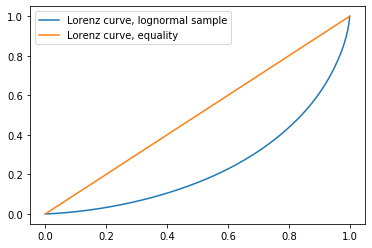

In [3]:
f_vals, l_vals = qe.lorenz_curve(w)

fig, ax = plt.subplots()
ax.plot(f_vals, l_vals, label='Lorenz curve, lognormal sample')
ax.plot(f_vals, f_vals, label='Lorenz curve, equality')
ax.legend()
plt.show()

In [4]:
qe.gini_coefficient(w)

0.5209327715246072

## Data

The data we will be using comes from various sources such as the [World Inequality Database](https://wid.world/). We will also reproduce plots from [Our World In Data](https://ourworldindata.org/income-inequality).

We use aggregated data as it is more readily available across many different countries and allows access to all readers. 

There are some readily available microdata sets such as that of the US  Survey of Consumer Finances ([SCF](https://www.federalreserve.gov/econres/aboutscf.htm)) and from the [Bank of Italy](https://www.bancaditalia.it/statistiche/tematiche/indagini-famiglie-imprese/bilanci-famiglie/distribuzione-microdati/index.html). However in many countries, such as Australia, microdata is confidential, which makes it diffiuclt to share with readers.

I will first illustrate how we can use microdata sets such as the Italian data set as an example of how useful these data sets are when using the QuantEcon library for inequality. 

Then we will take a deep dive into the aggregated data across all different countries. 

### Italy

First we will import the data into a `pandas` dataframe.

In [16]:
italy_path = r'./inequality_data/boi/rfam.dta'
italy_data = pd.read_stata(italy_path)

In [17]:
# Display 6 columns for viewing purposes
pd.set_option('display.max_columns', 10)
italy_data.head()

,nquest,anno,yl,yl1,yl2,...,y,ycf1l,ycf2l,ycf3l,ycfl
0,1,1977,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
1,2,1977,774.685364,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,3,1977,4157.478027,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
3,4,1977,4131.655273,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,5,1977,2024.510986,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


The varible we are interested in is Net disposable income which is `y`. You can find documentation for this on page 7 [here](https://www.bancaditalia.it/statistiche/tematiche/indagini-famiglie-imprese/bilanci-famiglie/documentazione/Shiw-Historical-Database.pdf?language_id=1).

In [18]:
italy_income = italy_data[['anno','y']]

In [19]:
italy_income.head()

,anno,y
0,1977,NaN
1,1977,NaN
2,1977,NaN
3,1977,NaN
4,1977,NaN


To help ourselves out we will rename the columns to year and income.

In [20]:
italy_income = italy_income.rename(columns={"anno": "year", "y": "income"})
italy_income.head()

,year,income
0,1977,NaN
1,1977,NaN
2,1977,NaN
3,1977,NaN
4,1977,NaN


We can see this data from starts from the year 1977. However the survey did not report Net disposable income until 1987. Thus we will only look at data from 1987 onwards.

In [21]:
italy_income = italy_income[italy_income['year'] >= 1987]

In [22]:
italy_income.head()

,year,income
36184,1987,26520.869141
36185,1987,7599.146973
36186,1987,12669.238281
36187,1987,5681.025879
36188,1987,33535.875000


Now we have the data we want lets plot the lorenz curve for the first year and the last year of the data set.

In [23]:
italy_87 = np.array(italy_income[italy_income['year']==1987]['income'])
italy_87.sort()
italy_16 = np.array(italy_income[italy_income['year']==2016]['income'])
italy_16.sort()

x_87, y_87 = qe.lorenz_curve(italy_87)
x_16, y_16 = qe.lorenz_curve(italy_16)

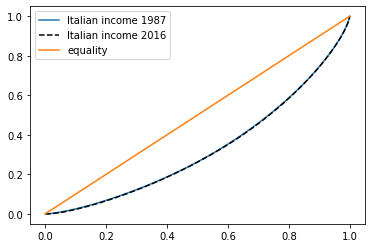

In [24]:
fig, ax = plt.subplots()
ax.plot(x_87, y_87, label='Italian income 1987')
ax.plot(x_16, y_16,'k--', label='Italian income 2016')
ax.plot(x_87, x_87, label='equality')
ax.legend()
plt.show()

It doesn't look like there has been to much of a change from 1987 to 2016. Lets look at the rank size plot.

In the wealth dynamics [lecture](https://python.quantecon.org/wealth_dynamics.html#Lorenz-Curves) we illustrated how the pareto tail index affected the lorenz curve. [Vries and Toda](http://www.lisdatacenter.org/wps/liswps/794.pdf) (2020) use data from the Luxembourg Income Study [(LIS)](https://www.lisdatacenter.org/) Database to esitmate the capital and labor income Pareto exponents across 51 countries over half a century. They use a simple dynamic model of consumption and savings similar to that of the our income flucation [lecture](https://python.quantecon.org/ifp_advanced.html) to explain their findings.

We could use this data to estimate the pareto exponent for Italy...

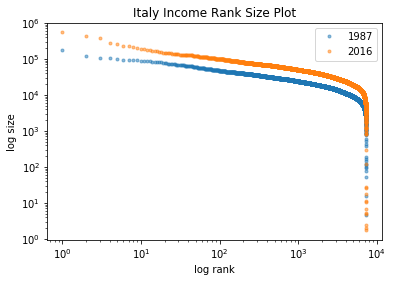

In [25]:
fig, ax = plt.subplots()
ax.set_title('Italy Income Rank Size Plot')
qe.rank_size_plot(italy_87,ax, label='1987')
qe.rank_size_plot(italy_16,ax, label='2016')

We can see that the rank size plot us shifted upwards. 

Let see if there has been much of a change in the gini coefficient over the years. 

In [26]:
years_italy = np.array(italy_income['year'].drop_duplicates())
years_italy

array([1987, 1989, 1991, 1993, 1995, 1998, 2000, 2002, 2004, 2006, 2008,
       2010, 2012, 2014, 2016], dtype=int16)

In [27]:
gini_italy =[]
for year in years_italy:
    year_income = np.array(italy_income[italy_income['year']==year]['income'])
    gini_italy.append(qe.gini_coefficient(year_income))

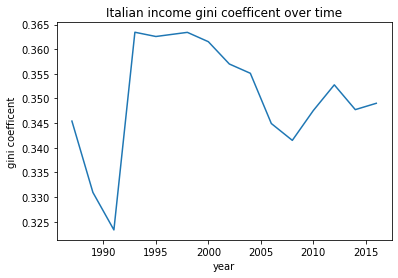

In [28]:
plt.figure()
plt.plot(years_italy,gini_italy)
plt.title('Italian income gini coefficient over time')
plt.xlabel('year')
plt.ylabel('gini coefficent')

plt.show()

We can clearly see the value in microdata as it allows us to gain a great understanding of the distribution of income. It is required to plot a accurate lorenz curve and rank size plot. 


Using any other type of aggragated household data (such a percentiles) to plot these graphs would be misleading as these plots require smoothness, Percentiles do not give enough data points.

Lets now look at the gini coefficients and income shares of countries over time using aggregated data.

## Income inequality across time and countries

We will first look at a data set from [World Inequality Database](https://wid.world/) to plot the difference in income share between the top 10% and the bottom 50% of the population. 

In [45]:
wid = pd.read_csv(r'./inequality_data/wid/WID_income_clean.csv')
wid.head()

,percentile,year,variable,values,country
0,p90p100,1871,Pre-tax national income,NaN,Switzerland
1,p90p100,1872,Pre-tax national income,NaN,Switzerland
2,p90p100,1873,Pre-tax national income,NaN,Switzerland
3,p90p100,1874,Pre-tax national income,NaN,Switzerland
4,p90p100,1875,Pre-tax national income,NaN,Switzerland


In [46]:
top10, mdl40, btm50, top1 = 'p90p100', 'p50p90', 'p0p50', 'p99p100'

This dataset has many countries, we will compare the inocme share over time for the United Kingdom, Italy, China, and the USA but feel free the change these to any of the countries in the data set.

In [20]:
wid.country.unique()

array(['Switzerland', 'Uruguay', 'Syrian Arab Republic', 'Guinea',
       'Malawi', 'Slovakia', 'Zambia', 'Eritrea', 'Kenya', 'Ireland',
       'United Arab Emirates', 'Sao Tome and Principe', 'Lithuania',
       'Japan', 'Germany', 'Greece', 'Mozambique', 'Nigeria', 'Ethiopia',
       'China', 'Jordan', 'Korea', 'Cote d’Ivoire', 'Namibia',
       'South Sudan', 'Malta', 'Mauritania', 'Russian Federation',
       'Mauritius', 'Bulgaria', 'Palestine', 'Hungary', 'Lesotho',
       'Lebanon', 'Bosnia and Herzegovina', 'Egypt', 'Cameroon', 'India',
       'Italy', 'Bahrain', 'Canada', 'Saudi Arabia', 'Algeria', 'Austria',
       'South Africa', 'Gabon', 'Rwanda', 'Uganda', 'Montenegro', 'Spain',
       'Somalia', 'German Democratic Republic', 'Kuwait', 'Croatia',
       'Guinea-Bissau', 'Netherlands', 'Togo', 'Ghana', 'Yemen', 'Gambia',
       'USA', 'Chad', 'Zimbabwe', 'Seychelles', 'Romania', 'Burkina Faso',
       'Mali', 'New Zealand', 'Burundi', 'Norway', 'Liberia', 'Benin',
       'T

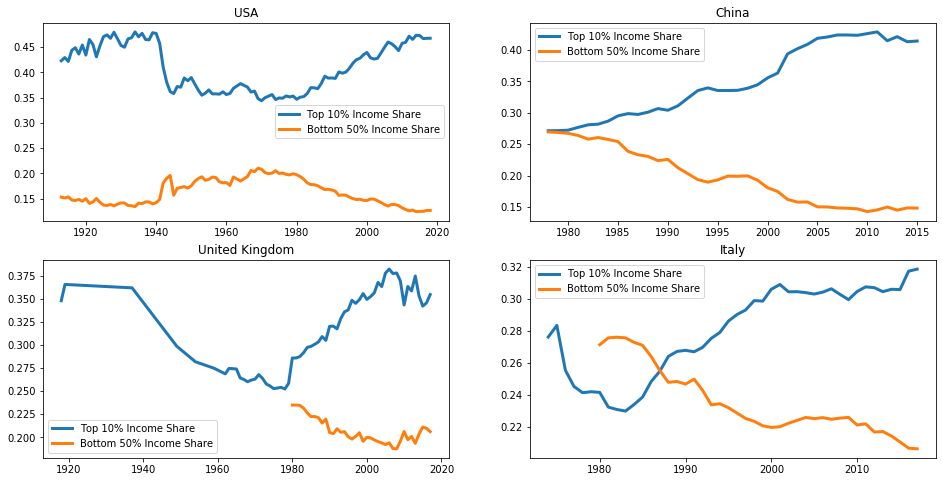

In [29]:
countries = ['USA', 'China', 'United Kingdom', 'Italy']

fig, axes = plt.subplots(2, 2, figsize=(16,8))
for i, ax in zip(range(len(countries)), axes.flat):
    country = countries[i]
    d2 = wid[((wid.country == country) & (wid.percentile == top10))].dropna()
    d4 = wid[((wid.country == country) & (wid.percentile == btm50))].dropna()
    ax.plot(d2.year, d2['values'], label='Top 10% Income Share', linewidth=3)
    ax.plot(d4.year, d4['values'], label='Bottom 50% Income Share', linewidth=3)
    ax.set_title(country)
    ax.legend()

If we compare the italian top 10% graph to the italian gini coefficent graph above, We can see why there was a large jump in the gini coefficient between 1992 and 1995. The top 10% income share significantly increased while there was a large drop in the bottom 50% income share. Infact this is a trend across all four countries above and we will see if this is also reflected in the gini coefficent of the USA, UK and china. 

Another interesting feature of the graph for the USA, the UK and Italy is the 'U' shape. We can see that there is a dip the top percetiles income share between the 1940s to the 1980s. Then it begins to increase again. It is an interesting obersvation as it is around this time that their industrial stuctures changed, there during the time there has been rapid advancments in technology. We should also see this 'U' shape reflected in the gini coefficent for these countries. For more discusiion on this see page 166 of Principles of Macroeconomics by Frank and Bernanke. 

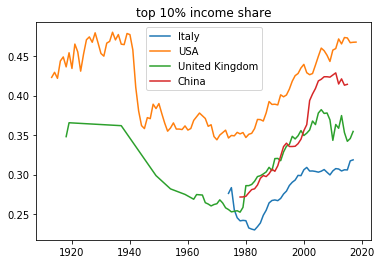

In [52]:
world_top10 = wid[wid['percentile'] == top10].dropna()
countries = ['Italy','USA', 'United Kingdom','China' ]
fig,ax = plt.subplots()

for country in countries:
    country_top10 = world_top10[world_top10['country'] == country]
    ax.plot(country_top10.year, country_top10['values'], label=f'{country}')
    ax.legend()
plt.title('top 10% income share')
plt.show()

Lets see if these inocme shares are reflected in the countries gini coefficnets.

I have collated data on gini coefficients for the [Australian Bureau of Statistics](https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/6523.0~2017-18~Main%20Features~Distribution%20of%20Household%20Income%20and%20Wealth~6), the UK [Office of National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/bulletins/householdincomeinequalityfinancial/financialyearending2019provisional) and the [Federal Reserve of St. Louis](https://fred.stlouisfed.org/series/SIPOVGINICHN). 

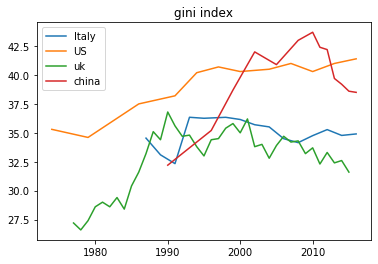

In [53]:
my_gini = pd.read_excel('./inequality_data/gini_coefficents.xlsx')
countries = ['US', 'uk', 'china']
fig,ax = plt.subplots()

ax.plot(years_italy, 100*np.array(gini_italy), label='Italy')
for country in countries:
    gini = my_gini[['year',country]].dropna()
    
    ax.plot(gini['year'], gini[country], label=country)
    
ax.legend()
plt.title('gini index')
plt.show()

## References
\[1] Principles of Macroeconomics Robert H. Frank and Ben S. Bernanke 